# Tutorial 1 — Poisson GLM

This is a tutorial illustrating the fitting of a linear-Gaussian GLM
(also known as linear least-squares regression model) and a Poisson GLM
(aka  "linear-nonlinear-Poisson" model) to retinal ganglion cell spike
trains stimulated with binary temporal white noise. 

(Data from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details).
The dataset can be downloaded [here](https://pillowlab.princeton.edu/data/data_RGCs.zip):

The dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu).

*Last updated: Mar 10, 2020 (JW Pillow)*

---
### How to use this tutorial:

This is an interactive tutorial designed to walk you through the steps of
fitting two classic models (linear-Gaussian GLM and Poisson GLM) to spike
train data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


--------------------------
Loaded RGC data: cell 2
Number of stim frames: 144051 (1201.5 minutes)
Time bin size: 8.3 ms
Number of spikes: 49954 (mean rate=41.6 Hz)


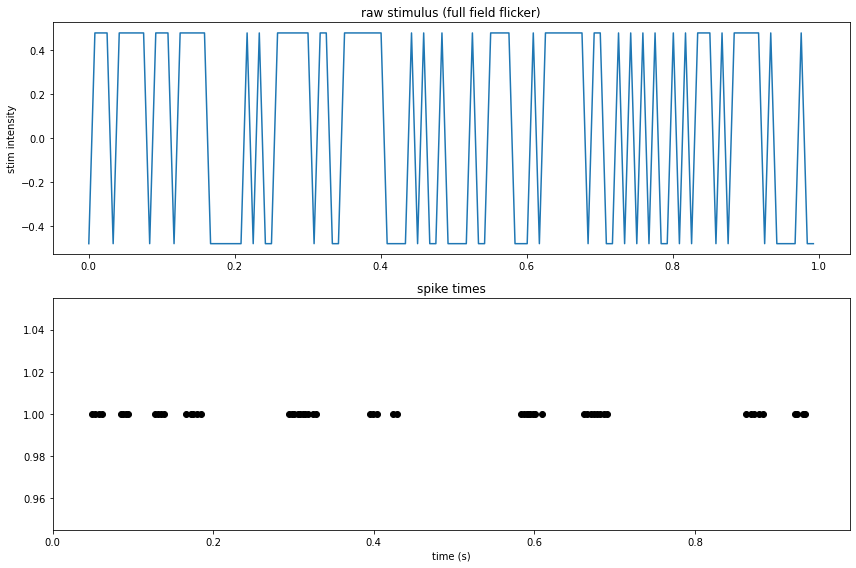

In [3]:
# let's work with the third cell for now
cell_idx = 2
spike_times = all_spike_times[cell_idx]

# Print out some basic info
dt_stim = stim_times[1] - stim_times[0] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = stim.size # number of time bins in stimulus
num_spikes = spike_times.size # number of spikes
print('--------------------------')
print(f'Loaded RGC data: cell {cell_idx}')
print(f'Number of stim frames: {num_time_bins} ({num_time_bins*dt_stim:.1f} minutes)')
print(f'Time bin size: {dt_stim*1000:.1f} ms')
print(f'Number of spikes: {num_spikes} (mean rate={num_spikes/num_time_bins*refresh_rate:.1f} Hz)')

# Let's visualize some of the raw data
fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(12,8)
iiplot = np.arange(120)
ttplot = iiplot*dt_stim
ax1.plot(ttplot, stim[iiplot])
ax1.set_title('raw stimulus (full field flicker)')
ax1.set_ylabel('stim intensity')

spike_times_plot = spike_times[(spike_times>=ttplot[0]) & (spike_times<ttplot[-1])]
ax2.plot(spike_times_plot, [1]*spike_times_plot.size, 'ko')
ax2.set_xlim([ttplot[0], ttplot[-1]])
ax2.set_xlabel('time (s)')
ax2.set_title('spike times')
plt.tight_layout()
plt.show()

<ipython-input-4-f030a3b2f214>:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(ttplot,spikes_binned[iiplot])


<Figure size 432x288 with 0 Axes>

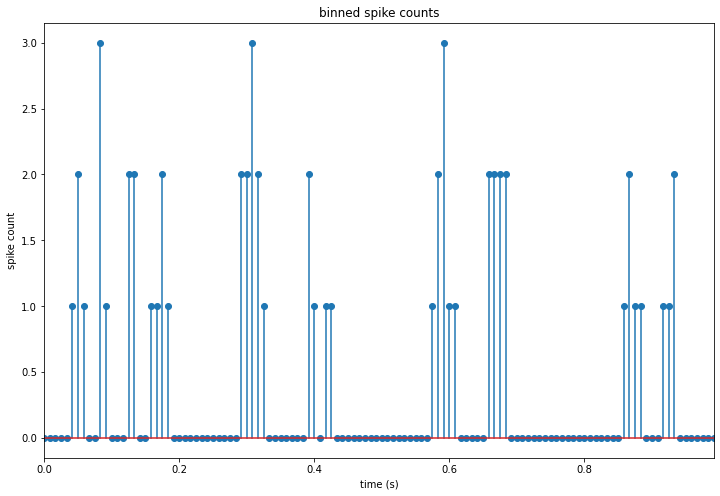

In [4]:
### ==== 2. Bin the spike train ===== 

# For now we will assume we want to use the same time bin size as the time
# bins used for the stimulus. Later, though, we'll wish to vary this.

spikes_bin_centers = np.arange(num_time_bins+1) * dt_stim # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

### Replot the responses we'll putting into our regression as counts
plt.clf()
plt.figure(figsize=[12,8])
plt.stem(ttplot,spikes_binned[iiplot])
plt.title('binned spike counts')
plt.ylabel('spike count')
plt.xlabel('time (s)')
plt.xlim([ttplot[0],ttplot[-1]])
plt.show()

<Figure size 432x288 with 0 Axes>

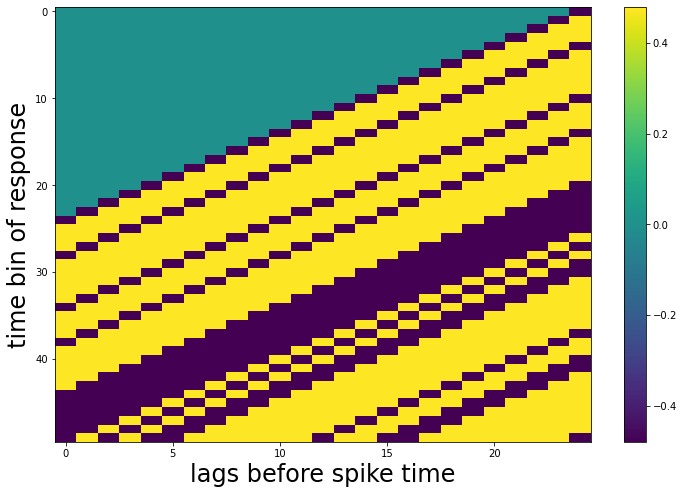

In [5]:
### ==== 3. Build the design matrix: slow version ======
# This is a necessary step before we can fit the model: assemble a matrix
# that contains the relevant regressors for each time bin of the response,
# known as a design matrix.  Each row of this matrix contains the relevant
# stimulus chunk for predicting the spike count at a given time bin

# Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 25     # Try varying this, to see how performance changes!

# Build the design matrix: Slow version
padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
design_mat = np.zeros((num_time_bins,ntfilt))
for j in np.arange(num_time_bins):
    design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    
# Let's visualize a small part of the design matrix just to see it
plt.clf()
plt.figure(figsize=[12,8])
plt.imshow(design_mat[:50], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time', fontsize=24)
plt.ylabel('time bin of response', fontsize=24)
plt.colorbar()
plt.show()

# Notice it has a structure where every row is a shifted copy of the row
# above, which comes from the fact that for each time bin of response,
# we're grabbing the preceding 'nkt' bins of stimulus as predictor

<Figure size 432x288 with 0 Axes>

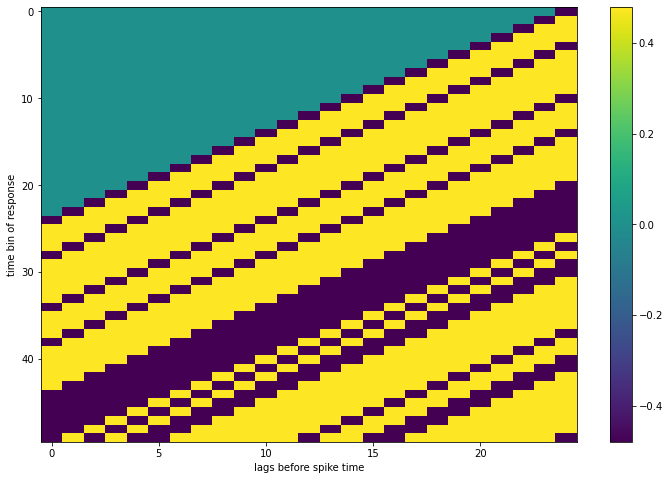

In [6]:
### ==== 3b. Build the design matrix: fast version =======

# Of course there's a faster / more elegant way to do this. The design
# matrix here is known as a 'Hankel' matrix, which is the same as a
# Toeplitz matrix flipped left to right.

### With no for loop
from scipy.linalg import hankel

padded_stim = np.hstack((np.zeros(ntfilt-1), stim))   # pad early bins of stimulus with zero
design_mat = hankel(padded_stim[:-ntfilt+1], stim[-ntfilt:])

# (You can check for you like that this gives the same matrix as the one created above!)

plt.clf()
plt.figure(figsize=[12,8])
plt.imshow(design_mat[:50], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

In [7]:
design_mat.shape

(144051, 25)

<Figure size 432x288 with 0 Axes>

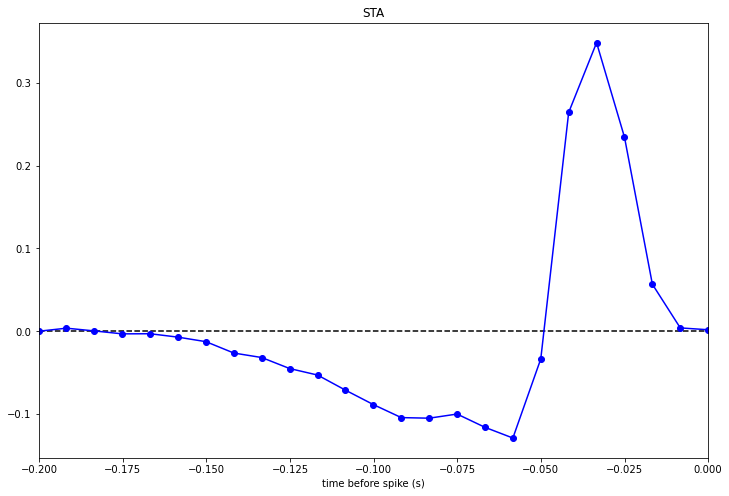

In [8]:
### === 4. Compute and visualize the spike-triggered average (STA) ====

# When the stimulus is Gaussian white noise, the STA provides an unbiased
# estimator for the filter in a GLM / LNP model (as long as the nonlinearity
# results in an STA whose expectation is not zero; feel free 
# to ignore this parenthetical remark if you're not interested in technical
# details. It just means that if the nonlinearity is symmetric, 
# eg. x^2, then this condition won't hold, and the STA won't be useful).

# In many cases it's useful to visualize the STA (even if your stimuli are
# not white noise), just because if we don't see any kind of structure then
# this may indicate that we have a problem (e.g., a mismatch between the
# design matrix and binned spike counts.

### It's extremely easy to compute the STA now that we have the design matrix
sta = (design_mat.T @ spikes_binned)/num_spikes

### Plot it
ttk = np.arange(-ntfilt+1,1)*dt_stim  # time bins for STA (in seconds)
plt.clf()
plt.figure(figsize=[12,8])
plt.plot(ttk,ttk*0, 'k--')
plt.plot(ttk, sta, 'bo-')
plt.title('STA')
plt.xlabel('time before spike (s)')
plt.xlim([ttk[0],ttk[-1]])
plt.show()

# If you're still using cell #1, this should look like a biphasic filter
# with a negative lobe just prior to the spike time.

# (By contrast, if this looks like garbage then it's a good chance we did something wrong!)

<Figure size 432x288 with 0 Axes>

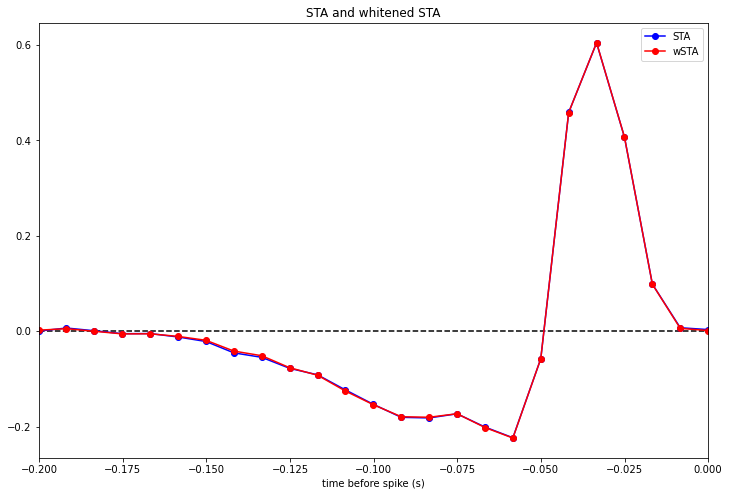

In [9]:
### ===== 4b. whitened STA (ML fit to filter for linear-Gaussian GLM) ======

# If the stimuli are non-white, then the STA is generally a biased
# estimator for the linear filter. In this case we may wish to compute the
# "whitened" STA, which is also the maximum-likelihood estimator for the filter of a 
# GLM with "identity" nonlinearity and Gaussian noise (also known as
# least-squares regression).

# If the stimuli have correlations this ML estimate may look like garbage
# (more on this later when we come to "regularization").  But for this
# dataset the stimuli are white, so we don't (in general) expect a big
# difference from the STA.  (This is because the whitening matrix
# (Xdsng.T * Xdsgn)^{-1} is close to a scaled version of the identity.)

from numpy.linalg import inv, norm
### whitened STA
wsta = inv(design_mat.T @ design_mat) @ sta * num_spikes
# this is just the least-squares regression formula!

### Let's plot them both (rescaled as unit vectors so we can see differences in their shape).
plt.clf()
plt.figure(figsize=[12,8])
plt.plot(ttk,ttk*0, 'k--')
plt.plot(ttk, sta/norm(sta), 'bo-', label="STA")
plt.plot(ttk, wsta/norm(wsta), 'ro-', label="wSTA")
plt.legend()
plt.title('STA and whitened STA')
plt.xlabel('time before spike (s)')
plt.xlim([ttk[0],ttk[-1]])
plt.show()

<ipython-input-10-41ea4f4a1e80>:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline,_,_ = plt.stem(ttplot,spikes_binned[iiplot], linefmt='b-', basefmt='k-', label="spike ct")


<Figure size 432x288 with 0 Axes>

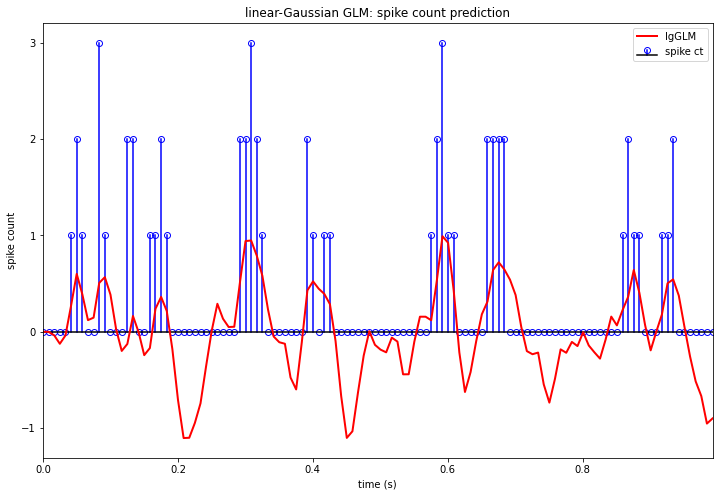

In [10]:
### ===== 4c. Predicting spikes with a linear-Gaussian GLM ======

# The whitened STA can actually be used to predict spikes because it
# corresponds to a proper estimate of the model parameters (i.e., for a
# Gaussian GLM). Let's inspect this prediction

sppred_lgGLM = design_mat @ wsta  # predicted spikes from linear-Gaussian GLM

# Let's see how good this "prediction" is
# (Prediction in quotes because we are (for now) looking at the performance
# on training data, not test data... so it isn't really aprediction!)

### Plot real spike train and prediction
plt.clf()
plt.figure(figsize=[12,8])
markerline,_,_ = plt.stem(ttplot,spikes_binned[iiplot], linefmt='b-', basefmt='k-', label="spike ct")
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'blue')
plt.plot(ttplot,sppred_lgGLM[iiplot], color='red', linewidth=2, label="lgGLM")
plt.title('linear-Gaussian GLM: spike count prediction')
plt.ylabel('spike count'); plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])
plt.legend()
plt.show()

<ipython-input-11-d5e46d4b3610>:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline,_,_ = plt.stem(ttplot,spikes_binned[iiplot], linefmt='b-', label="spike ct")


<Figure size 432x288 with 0 Axes>

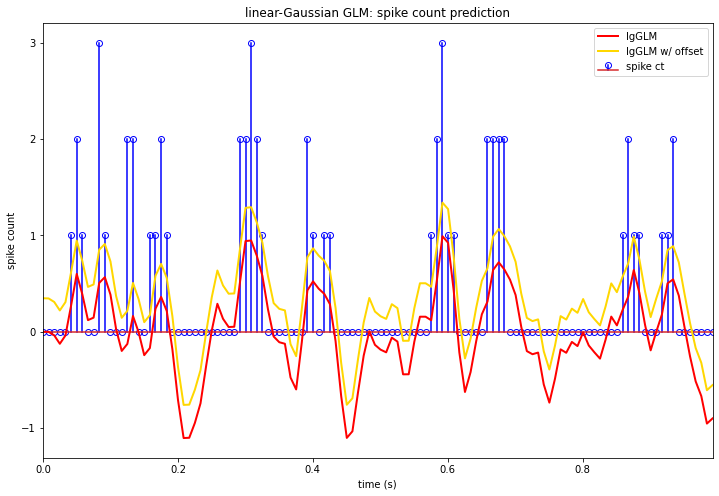

Training perf (R^2): lin-gauss GLM, no offset: 0.12
Training perf (R^2): lin-gauss GLM, w/ offset: 0.39


In [11]:
### ===== 4d. Fitting and predicting with a linear-Gaussian-GLM with offset =====

# Oops, one thing we forgot above was to include an offset or "constant"
# term in the design matrix, which will allow our prediction to have
# non-zero mean (since the stimulus here was normalized to have zero mean).

### Updated design matrix
design_mat_offset = np.hstack((np.ones((num_time_bins,1)), design_mat))     # just add a column of ones

### Compute whitened STA
wsta_offset = inv(design_mat_offset.T @ design_mat_offset) @ (design_mat_offset.T @ spikes_binned)  # this is just the LS regression formula
const = wsta_offset[0]   # the additive constant
wsta_offset = wsta_offset[1:]  # the linear filter part

### Now redo prediction (with offset)
sppred_lgGLM_offset = const + design_mat @ wsta_offset

### Plot this stuff
plt.clf()
plt.figure(figsize=[12,8])
markerline,_,_ = plt.stem(ttplot,spikes_binned[iiplot], linefmt='b-', label="spike ct")
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'blue')
plt.plot(ttplot,sppred_lgGLM[iiplot], color="red", linewidth=2, label = 'lgGLM')
plt.plot(ttplot,sppred_lgGLM_offset[iiplot], color="gold", linewidth=2, label = 'lgGLM w/ offset') 
plt.title('linear-Gaussian GLM: spike count prediction')
plt.ylabel('spike count'); plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])
plt.legend()
plt.show()

### Let's report the relevant training error (squared prediction error on
### training data) so far just to see how we're doing:
mse1 = np.mean((spikes_binned-sppred_lgGLM)**2)   # mean squared error, GLM no offset
mse2 = np.mean((spikes_binned-sppred_lgGLM_offset)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, no offset: {:.2f}'.format(1-mse1/rss))
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))

In [12]:
### ======  5. Poisson GLM ====================

# Let's finally move on to the LNP / Poisson GLM!

# Package available for download from
# https://www.statsmodels.org/stable/install.html
import statsmodels.api as sm

### This is super-easy if we rely on built-in GLM fitting code
glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                         family=sm.families.Poisson())

pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')


# pGLM_const = glm_poisson_exp[-1].fit_['beta0'] # constant ("dc term)")
pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

# The 'GLM' function can fit a GLM for us. Here we have specified that
# we want the noise model to be Poisson. The default setting for the link
# function (the inverse of the nonlinearity) is 'log', so default
# nonlinearity is 'exp').  

### Compute predicted spike rate on training data
rate_pred_pGLM = np.exp(pGLM_const + design_mat @ pGLM_filt)
# equivalent to if we had just written np.exp(design_mat_offset @ glm_poisson_exp)/dt_stim

<ipython-input-13-9e3ce59e6ffa>:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline,stemlines,baseline = plt.stem(ttplot,spikes_binned[iiplot], label="spike count", linefmt='b-', basefmt='b-')


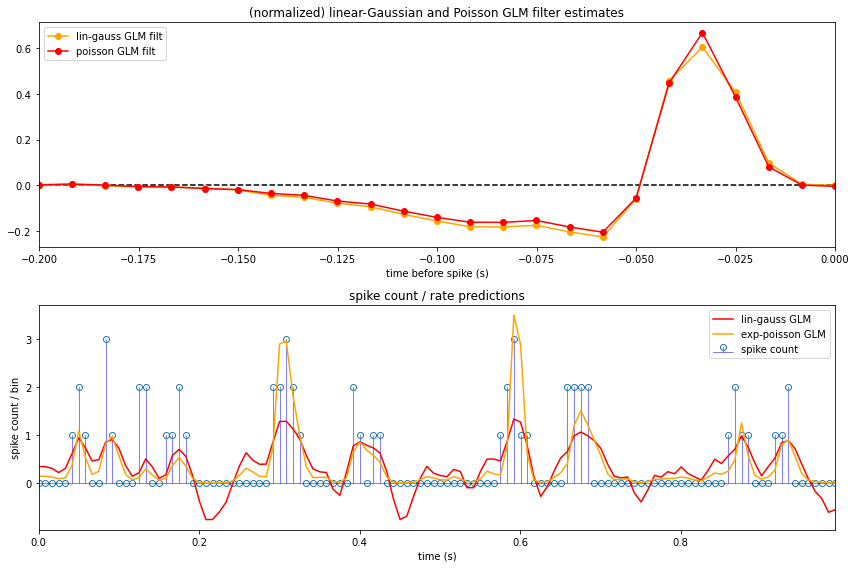

In [13]:
### ===== 5b. Make plots showing and spike rate predictions ======

plt.close()

fig, (ax1,ax2) = plt.subplots(2)
fig.set_size_inches(12,8)
ax1.plot(ttk,ttk*0, 'k--')
ax1.plot(ttk, wsta_offset/norm(wsta_offset), 'o-', label='lin-gauss GLM filt', c='orange')
ax1.plot(ttk, pGLM_filt/norm(pGLM_filt), 'o-', label='poisson GLM filt', c='r')
ax1.legend(loc = 'upper left')
ax1.set_title('(normalized) linear-Gaussian and Poisson GLM filter estimates')
ax1.set_xlabel('time before spike (s)')
ax1.set_xlim([ttk[0], ttk[-1]])

markerline,stemlines,baseline = plt.stem(ttplot,spikes_binned[iiplot], label="spike count", linefmt='b-', basefmt='b-')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(stemlines, color='b', linewidth=.5)
plt.setp(baseline, color='b', linewidth=.5)
ax2.plot(ttplot,sppred_lgGLM_offset[iiplot], label="lin-gauss GLM", c='r')
ax2.plot(ttplot,rate_pred_pGLM[iiplot], label="exp-poisson GLM", c='orange') 
ax2.set_title('spike count / rate predictions')
ax2.set_ylabel('spike count / bin'); plt.xlabel('time (s)')
ax2.set_xlim([ttplot[0], ttplot[-1]])
ax2.legend(loc='upper right')
plt.tight_layout()

# Note the rate prediction here is in units of spikes/bin. If we wanted
# spikes/sec, we could divide it by bin size dt_stim.

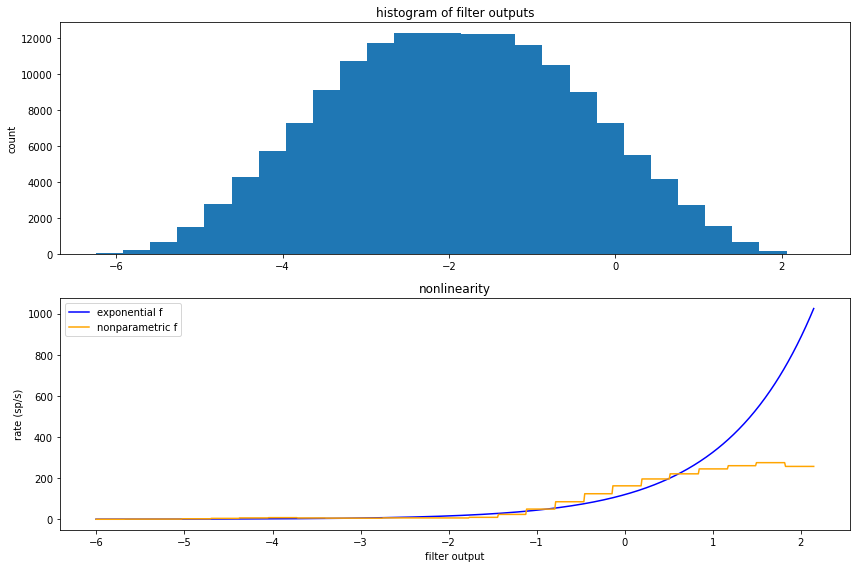

In [14]:
### ===== 6. Non-parametric estimate of the nonlinearity =====

# The above fitting code assumes a GLM with an exponential nonlinearity
# (i.e., governing the mapping from filter output to instantaneous spike
# rate). We might wish to examine the adequacy of that assumption and make
# a "nonparametric" estimate of the nonlinearity using a more flexible
# class of functions.

# Let's use the family of piece-wise constant functions, which results in a
# very simple estimation procedure:
# 1. Bin the filter outputs
# 2. In each bin, compute the fraction of stimuli elicted spikes

from scipy.interpolate import interp1d

# number of bins for parametrizing the nonlinearity f. (Try varying this!) 
num_fbins = 25

# compute filtered stimulus
raw_filter_output = pGLM_const + design_mat @ pGLM_filt

# bin filter output and get bin index for each filtered stimulus
counts,bin_edges = np.histogram(raw_filter_output,num_fbins);
bin_idx = np.digitize(raw_filter_output, bins=bin_edges) - 1
fx = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2 # use bin centers for x positions

# now compute mean spike count in each bin
fy = np.zeros(num_fbins) # y values for nonlinearity
for jj in np.arange(num_fbins):
    fy[jj] = np.mean(spikes_binned[bin_idx==jj])
fy = fy/dt_stim # divide by bin size to get units of sp/s;

# Scipy has a handy class that embeds these approximations into an interpolating function
fnlin = interp1d(fx,fy,kind='nearest', bounds_error=False, fill_value='extrapolate')

# Make plots
plt.close()

fig, (ax1,ax2) = plt.subplots(2) # Plot exponential and nonparametric nonlinearity estimate
fig.set_size_inches(12,8)
ax1.bar(fx,counts)
ax1.set_ylabel('count')
ax1.set_title('histogram of filter outputs')

xx = np.arange(bin_edges[0], bin_edges[-1]+.01, step=.01)
ax2.plot(xx,np.exp(xx)/dt_stim, label='exponential f', c='b')
ax2.plot(xx,fnlin(xx), label='nonparametric f', c='orange')
ax2.set_xlabel('filter output')
ax2.set_ylabel('rate (sp/s)')
ax2.legend(loc='upper left')
ax2.set_title('nonlinearity')
plt.tight_layout()

# What do you think of the exponential fit? Does this look like a good
# approximation to the nonparametric estimate of the nonlinearity?  Can you
# propose a better parametric nonlinearity to use instead?  

# Advanced exercise: write your own log-likelihood function that allows you
# to jointly optimize log-likelihood for the filter parameters and
# nonlinearity.  (By contrast, here we have optimized filter params under
# exponential nonlinearity and THEN fit the nonlinearity using these fixed
# filter parameters).  We could, for example, iteratively climb the
# log-likelihood as a function of filter params and nonlinearity params;
# this is a method known as "coordinate ascent").

In [15]:

rate_pred_pGLM.shape

(144051,)

Exp. GLM, LL: -64575.890125074446
Non-parametric GLM, LL: -61290.53429206769
Constant, LL: -102858.52409681036

 empirical single-spike information:
 ---------------------- 
exp-GLM: 1.11 bits/sp
 np-GLM: 1.20 bits/sp


<ipython-input-22-cd49e33390e2>:58: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline,stemlines,baseline = plt.stem(ttplot,spikes_binned[iiplot], label="spike count", linefmt='b-', basefmt='b-')


<Figure size 432x288 with 0 Axes>

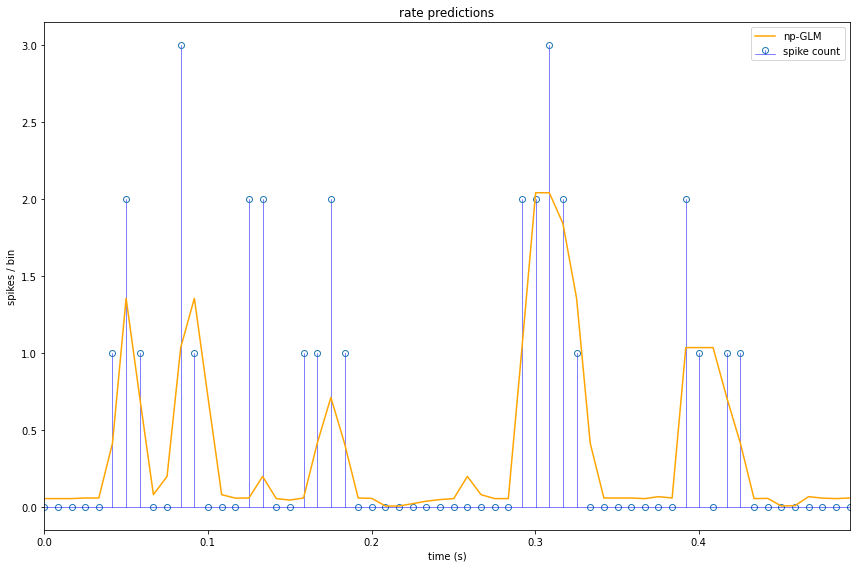

In [22]:
### ======= 7. Quantifying performance: log-likelihood =======

# Lastly, compute log-likelihood for the Poisson GLMs we've used so far and
# compare performance.

# LOG-LIKELIHOOD (this is what glmfit maximizes when fitting the GLM):
# --------------
# Let s be the spike count in a bin and r is the predicted spike rate
# (known as "conditional intensity") in units of spikes/bin, then we have:   
#
#        Poisson likelihood:      P(s|r) = r^s/s! exp(-r)  
#     giving log-likelihood:  log P(s|r) =  s log r - r   
#
# (where we have ignored the -log s! term because it is independent of the
# parameters). The total log-likelihood is the summed log-likelihood over
# time bins in the experiment.

# 1. for GLM with exponential nonlinearity
rate_pred_pGLM = np.exp(pGLM_const + design_mat@pGLM_filt)# rate under exp nonlinearity
LL_expGLM = spikes_binned[spikes_binned>0].T @ np.log(rate_pred_pGLM[spikes_binned>0]) - np.sum(rate_pred_pGLM)
print(f"Exp. GLM, LL: {LL_expGLM}")

# 2. for GLM with non-parametric nonlinearity
rate_pred_pGLMnp = dt_stim * fnlin(pGLM_const + design_mat @ pGLM_filt) # rate under nonpar nonlinearity
LL_npGLM = spikes_binned[spikes_binned>0].T @ np.log(rate_pred_pGLMnp[spikes_binned>0]) - np.sum(rate_pred_pGLMnp)
print(f"Non-parametric GLM, LL: {LL_npGLM}")

# Now compute the rate under "homogeneous" Poisson model that assumes a
# constant firing rate with the correct mean spike count.
rate_pred_const = num_spikes/num_time_bins  # mean number of spikes / bin
LL0 = num_spikes*np.log(rate_pred_const) - num_time_bins*rate_pred_const
print(f"Constant, LL: {LL0}")

# Single-spike information:
# ------------------------
# The difference of the loglikelihood and homogeneous-Poisson
# loglikelihood, normalized by the number of spikes, gives us an intuitive
# way to compare log-likelihoods in units of bits / spike.  This is a
# quantity known as the (empirical) single-spike information.
# [See Brenner et al, "Synergy in a Neural Code", Neural Comp 2000].
# You can think of this as the number of bits (number of yes/no questions
# that we can answer) about the times of spikes when we know the spike rate
# output by the model, compared to when we only know the (constant) mean
# spike rate. 

SSinfo_expGLM = (LL_expGLM - LL0)/num_spikes/np.log(2)
SSinfo_npGLM = (LL_npGLM - LL0)/num_spikes/np.log(2)
# (if we don't divide by log 2 we get it in nats)

print('\n empirical single-spike information:\n ---------------------- ')
print(f'exp-GLM: {SSinfo_expGLM:.2f} bits/sp')
print(f' np-GLM: {SSinfo_npGLM:.2f} bits/sp')

# Let's plot the rate predictions for the two models 
# --------------------------------------------------
plt.clf()
plt.figure(figsize=[12,8])
markerline,stemlines,baseline = plt.stem(ttplot,spikes_binned[iiplot], label="spike count", linefmt='b-', basefmt='b-')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(stemlines, color='b', linewidth=.5)
plt.setp(baseline, color='b', linewidth=.5)
# plt.plot(ttplot,rate_pred_pGLM[iiplot], label='exp-GLM', c='r')
plt.plot(ttplot,rate_pred_pGLMnp[iiplot], label='np-GLM', c='orange')
plt.title('rate predictions')
plt.ylabel('spikes / bin')
plt.xlabel('time (s)')
plt.xlim([ttplot[0], ttplot[-1]])
plt.legend()
plt.tight_layout()

In [17]:
### ========== 8. Quantifying performance: AIC =============

# Akaike information criterion (AIC) is a method for model comparison that
# uses the maximum likelihood, penalized by the number of parameters.
# (This allows us to compensate for the fact that models with more
# parameters can in general achieve higher log-likelihood. AIC determines
# how big this tradeoff should be in terms of the quantity:
#        AIC = - 2*log-likelihood + 2 * number-of-parameters
# The model with lower AIC is 
# their likelihood (at the ML estimate), penalized by the number of parameters  

AIC_expGLM = -2*LL_expGLM + 2*(1+ntfilt);
AIC_npGLM = -2*LL_npGLM + 2*(1+ntfilt+num_fbins)

print('\n AIC comparison:\n ---------------------- ')
print(f'exp-GLM: {AIC_expGLM:.1f}')
print(f' np-GLM: {AIC_npGLM:.1f}')
print(f'\nAIC diff (exp-np)= {AIC_expGLM-AIC_npGLM:.2f}')
if AIC_expGLM < AIC_npGLM:
    print('AIC supports exponential-nonlinearity!')
else:
    print('AIC supports nonparametric nonlinearity!')
    # (despite its greater number of parameters)

# Caveat: technically the AIC should be using the maximum of the likelihood
# for a given model.  Here we actually have an underestimate of the
# log-likelihood for the non-parameteric nonlinearity GLM because
# because we left the filter parameters unchanged from the exponential-GLM.
# So a proper AIC comparison (i.e., if we'd achieved a true ML fit) would
# favor the non-parametric nonlinearity GLM even more!

# Exercise: go back and increase 'nfbins', the number of parameters (bins)
# governing the nonparametric nonlinearity. If you increase it enough, you
# should be able to flip the outcome so exponential nonlinearity wins.

# (Note: in the third tutorial we'll use cross-validation to properly
# evaluate the goodness of the fit of the models, e.g., allowing us to
# decide how many bins of stimulus history or how many bins to use for the
# non-parametric nonlinearity, or how to set regularization
# hyperparameters. The basic idea is to split data into training and test
# sets.  Fit the parameters on the training set, and compare models by
# evaluating log-likelihood on test set.)


 AIC comparison:
 ---------------------- 
exp-GLM: 129203.8
 np-GLM: 122683.1

AIC diff (exp-np)= 6520.71
AIC supports nonparametric nonlinearity!


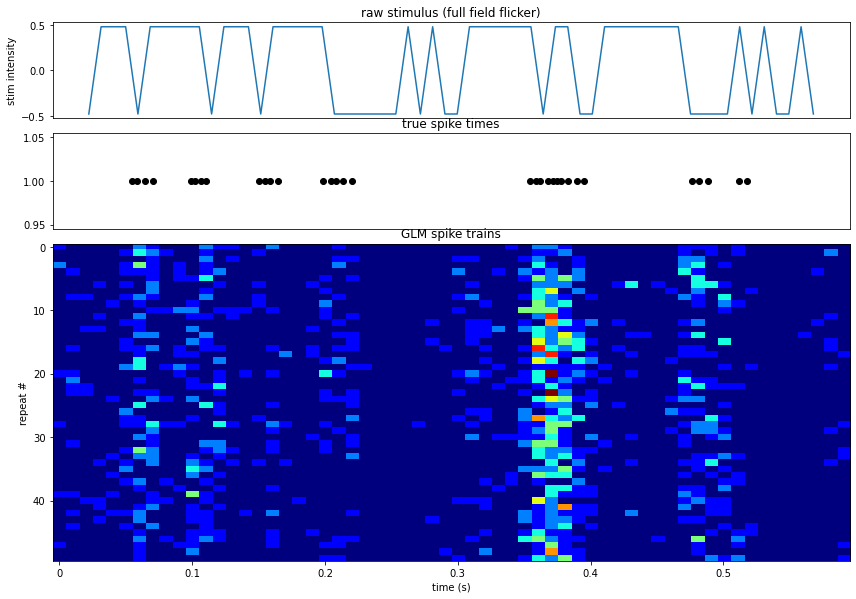

In [18]:
### ========= 9. Simulating the GLM / making a raster plot =========

# Lastly, let's simulate the response of the GLM to a repeated stimulus and
# make raster plots 

iiplot = np.arange(60) # time bins of stimulus to use
ttplot = iiplot*dt_stim # time indices for these stimuli
stim_repeat = stim[iiplot] # repeat stimulus 
num_repeats = 50;  # number of repeats
f_rate = np.exp(pGLM_const + design_mat[iiplot,:] @ pGLM_filt)# firing rate in each bin

# Or uncomment this line to use the non-parametric nonlinearity instead:
#frate = dt_stim*fnlin(pGLM_const+design_mat[iiplot,:]@pGLM_filt) # firing rate in each bin

# First, plot stimulus and true spikes
plt.close()
fig = plt.figure(figsize=[12,8])
plt.subplot(10,1,(1,2))
plt.plot(ttplot,stim[iiplot])
plt.title('raw stimulus (full field flicker)')
plt.ylabel('stim intensity')
plt.xticks([])
plt.tight_layout()


plt.subplot(10,1,(3,4))
plt.plot(spike_times_plot, [1]*spike_times_plot.size, 'ko')
plt.xlim([ttplot[0],ttplot[-1]])
plt.title('true spike times')
plt.xticks([])

# Simulate spikes using draws from a Bernoulli (coin flipping) process
spike_counts = np.random.poisson(np.tile(f_rate.T,[num_repeats,1])) # sample spike counts for each time bin
plt.subplot(10,1,(5,10))
plt.imshow(spike_counts, cmap='jet', aspect='auto')
plt.ylabel('repeat #')
plt.xlabel('time (s)')
plt.title('GLM spike trains')
_,_ = plt.xticks(ticks=[0,10,20,30,40,50], labels=['0','0.1','0.2','0.3','0.4','0.5'])
# plt.tight_layout()

Text(0.5, 1.0, 'GLM spike trains')

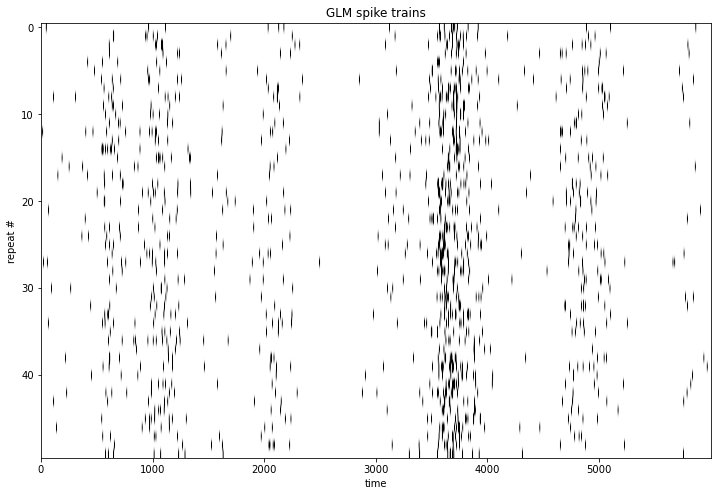

In [19]:
### ========== Optional: redo using finer time bins, so we get maximum 1 spike per bin =========

up_samp_factor = 100 # divide each time bin by this factor
dt_fine = dt_stim/up_samp_factor # use bins 100 time bins finer
tt_fine = np.arange(dt_fine/2, ttplot[-1]+dt_stim, step=dt_fine)

# Compute the fine-time-bin firing rate (which must be scaled down by bin width)
inter_func = interp1d(ttplot,f_rate,kind='nearest', bounds_error=False, fill_value='extrapolate')
f_rate_fine = inter_func(tt_fine).T/up_samp_factor

# now draw fine-timescale spike train
spike_counts_fine = np.random.poisson(np.tile(f_rate_fine,[num_repeats,1])) # sample spike counts for each time bin

# Make plot
# plt.subplot(10,1,(5,10))
fig = plt.figure(figsize=[12,8])
plt.imshow(spike_counts_fine, cmap='Greys', aspect='auto', vmin=0, vmax=.1)
plt.ylabel('repeat #')
plt.xlabel('time')
plt.title('GLM spike trains')

 ========= Suggested Exercises (advanced) =========
 -------------------------------

 1) Go back and try it out for the other three neurons!
 (Go to block 1 and change the variable 'cellnum' to 1, 2, or 3.)
 
 2) Write your own code to do maximum likelihood estimation of the filter
 and the nonlinearity.  Your function should take in the parameters for
 the filter and the nonlinearity, and compute the Poisson log-likelihood
 function, the log Probability of the spike responses given the stimuli
 and the parameters.  A nice way to parametrize the nonlinearity is with a
 linear combination of basis functions, e.g.
      ```f(x) = sum_i  w_i * f_i(x)```
 where f_i(x) is the i'th basis function and w_i is the weight on that
 basis function.  You can choose the f_i to be Gaussian bumps or sigmoids,
 i.e. ```f_i(x) = 1./(1+exp(-x - c_i))``` where c_i is the shift for the i'th
 basis function.

 Another alternative (that will prevent negative firing rates) is to
 parameterize the log-firing rate with a linear combination of basis
 functions, e.g.
  ```log(f(x)) = sum_i  w_i * f_i(x)```
        meaning that
  ```f(x) = exp(sum_i  w_i * f_i(x))```
  Now your weights can be negative or positive without fear of generating
  negative values (which will cause your negative log-likelihood function
  to give nans or -infs.  
  
  Write a function that takes in k and weight vector w and computes the
  Poisson log-likelihood.  Hand that function off to fminunc and compare
  the accuracy of the fits you get to the model with fixed exponential
  nonlinearity.